# Paralelismo en Julia

Julia cuenta con soporte para cuatro categorías de programación concurrente, paralela y distribuida:
1. Corutinas o tareas asíncronas
2. Multi-threading
3. Cómputo distribuido
4. Cómputo en GPU

***

## Corutinas

Son generalizaciones del concepto de subrutina, que permiten suspender y resumir su ejecución.

En Julia se implementan por medio del tipo `Task`, y son útiles para suspender y resumir cómputo en operaciones de E/S, manejo de eventos, procesos productor-consumidor, etc...

Una tarea tiene un ciclo de vida:
 - Creación
 - Inicialización
 - Ejecución
 - Fin
 
Cuando se crea una tarea, se le provee como argumento la expresión a ejecutar.

In [ ]:
function f_prueba()
    println("Hola desde la tarea")
    return :ok
end

t_prueba = Task(f_prueba)

En este punto, la tarea ya fue creada pero no se ha inicializado.

Se puede consultar si la tarea ya inició, y si ya finalizó:

In [ ]:
#Revisando si la tarea ya se inició
istaskstarted(t_prueba)

In [ ]:
#Revisando si la tarea ya finalizó
istaskdone(t_prueba)

Puede utilizarse la función `schedule` para iniciar la tarea.

In [ ]:
schedule(t_prueba)

Una vez que la tarea se ejecutó, se pueden ver los cambios en su estado:

In [ ]:
#Revisando si la tarea ya se inició
istaskstarted(t_prueba)

In [ ]:
#Revisando si la tarea ya finalizó
istaskdone(t_prueba)

Se puede consultar el valor de retorno de la tarea por medio de la instrucción `fetch`.

In [ ]:
fetch(t_prueba)

In [ ]:
function f_prueba()
    println("Hola desde la tarea")
    sleep(10)
    return :ok
end

t_prueba = Task(f_prueba)

schedule(t_prueba)

Si la tarea no ha finalizado, `fetch` bloqueará la ejecución hasta que termine la tarea.

In [ ]:
fetch(t_prueba)

Si se vuelve a intentar ejecutar la tarea, recibiremos un error:

In [ ]:
schedule(t_prueba)

Esto es debido a que la tarea llegó al final de su ciclo de vida.

Se pueden definir tareas usando el macro `@task`

In [ ]:
t = @task begin
    println("Iniciando tarea")
    sleep(5);
    println("mundo");
end

schedule(t);

println("hola")

Como se puede notar, la celda de código aparenta haber finalizado su ejecución antes de que la tarea escriba "mundo". Lo que sucede detrás es lo siguiente:
- El REPL (read-eval-print loop) de Julia ejecuta `schedule(t)`, y esto retorna inmediatamente. Entonces la tarea t se agrega a una cola interna de tareas que se deben de ejecutar.
- Se continúa con la ejecución de código, en este caso, escribiendo el "hola".
- Cuando se termina la celda, Julia nota que no se está realizando un proceso en el hilo. Esto causa que ejecute sus tareas pendientes.
- La tarea se empieza a ejecutar, primero escribiendo "Iniciando tarea".
- La tarea encuentra el `sleep(5)`, lo que genera que se suspenda la tarea por 5 segundos. Si existieran otras tareas pendientes, este sería un buen momento para que Julia las atendiera.
- Después de los 5 segundos, se escribe "mundo" y finaliza la tarea.

Existe otro macro utilizado en estos casos. `@async` genera la tarea y la inicializa.

In [ ]:
@async begin
    println("Iniciando tarea")
    sleep(5);
    println("mundo");
end

println("hola")

Por otro lado, el uso de la instrucción `wait` permite bloquear la ejecución hasta que una tarea se termine de ejecutar.

In [ ]:
t = @async begin
    println("Iniciando tarea")
    sleep(5);
    println("mundo");
end

wait(t)

println("hola")

#### Ejemplos de uso

Las tareas por sí mismas se ejecutan en el mismo hilo. Esto implica que son **concurrentes** pero **no paralelas** (se pueden interrumpir y reanudar, pero dos tareas no se ejecutan en el mismo instante de tiempo). Aunque más adelante veremos como podemos hacer que las tareas se ejecuten en paralelo, un comportamiento solamente concurrente es bueno para tareas en las que existe una espera implícita que no depende del sistema.

Por ejemplo, se puede acelerar la adquisición de datos provenientes de red al utilizar tareas concurrentes para hacer las solicitudes y estar a la espera de la respuesta:

In [ ]:
#using Pkg
#Pkg.add("HTTP")
#Pkg.add("BenchmarkTools")
using HTTP, BenchmarkTools

#Lista de URLs a consultar
urls = ["https://julialang.org/" for i=1:10]

#Arreglo donde se guardan las respuestas
results = Array{HTTP.Messages.Response}(undef, 10)

#Se muestra el tiempo de adquisicion cuando las consultas se hacen secuencialmente
@btime for (i, url) in enumerate($urls)
    $results[i] = HTTP.get(url)
end

El código anterior solicita una URL, espera la respuesta, y una vez la recibe procede a solicitar la siguiente.

En contraste el código siguiente genera una tarea por URL, por lo que se realizan todas las solicitudes sin importar si las otras ya retornaron una respuesta o no.

In [ ]:
#Se muestra el tiempo de adquisicion cuando las consultas se hacen concurrentemente
@btime @sync for (i, url) in enumerate($urls)
    @async $results[i] = HTTP.get(url)
end

En este caso, el macro `@sync` funciona de manera similar a la función `wait`. Todas las tareas generadas dentro del segmento de código al que envuelve deberán finalizar para que el bloque se tome por finalizado.

Debido a que la espera asociada a las operaciones no depende del equipo, sino de factores externos como la conexión y el tiempo de respuesta de los servidores, se puede acelerar la operación al utilizar tareas concurrentes.

### Canales

Un `Channel` es un mecanismo que permite que varias tareas se comuniquen sin la necesidad de hacer llamadas de funciones entre ellas. Es una cola de orden primero entrada, primero salida (FIFO) con facilidades de espera. 

<div>
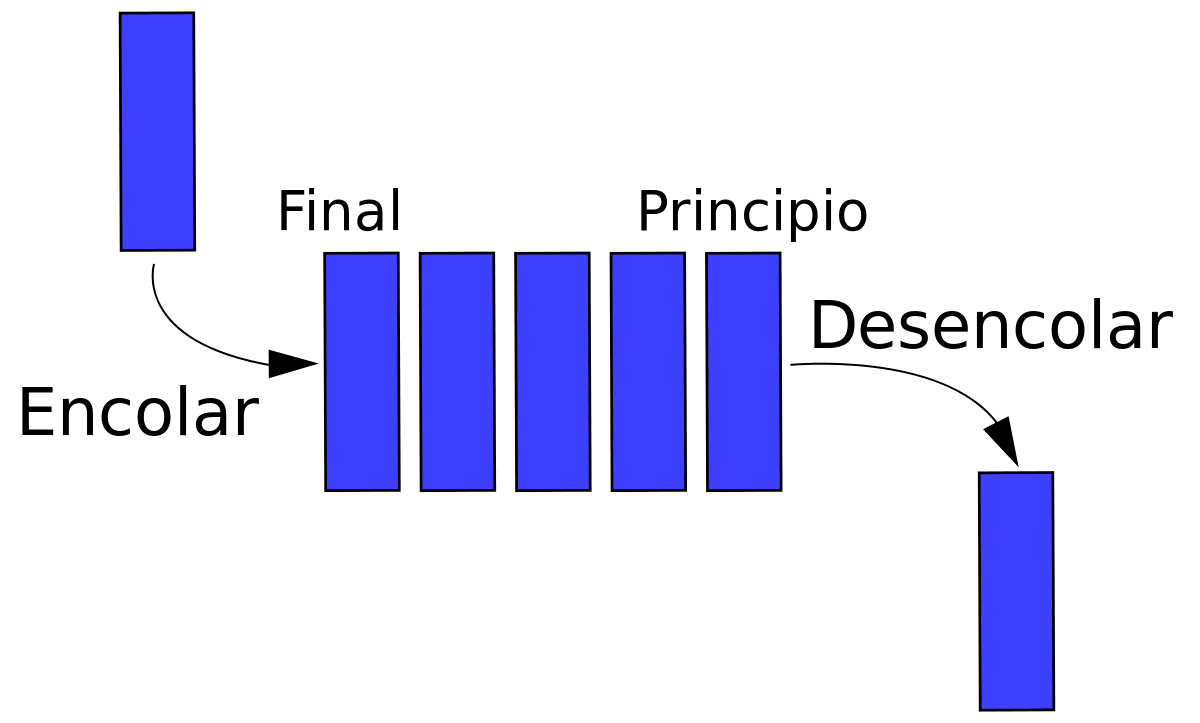
</div>
<center>
    Ilustración del funcionamiento de una cola FIFO. (Wikimedia Commons)
</center>

Varias tareas pueden leer y escribir a un mismo canal al mismo tiempo, por lo que se pueden utilizar como canales de comunicación.

In [ ]:
#Canal sin límite de tamaño
ch_no_limite = Channel(0)

In [ ]:
#Canal con tamaño limitado
ch = Channel(1024)

Pueden generarse canales de tamaño arbitrario o de tamaño limitado. La instrucción `isready` nos indica si existe al menos un elemento en el canal `ch`.

In [ ]:
isready(ch)

Los canales utilizan las instrucciones `put!` y `take!` para insertar y extraer elementos de la cola.

In [ ]:
put!(ch, 0)

In [ ]:
isready(ch)

In [ ]:
take!(ch) 

In [ ]:
isready(ch)

Si intentaramos insertar elementos cuando el canal está lleno o extraerlos cuando el canal está vacío, entraríamos en espera hasta que esto fuera posible. Para demostrar este comportamiento, generaremos tres tareas que intentarán insertar elementos al canal.

In [ ]:
t1 = @async begin
        for n=1:600
            put!(ch, 1)
        end
    end

t2 = @async begin
        for n=1:600
            put!(ch, 2)
        end
    end

t3 = @async begin
        for n=1:600
            put!(ch, 3)
        end
    end

Tarea 1

In [ ]:
#Revisando si la tarea t1 ya acabó
istaskdone(t1)

In [ ]:
#Revisando si la tarea t1 ya inició
istaskstarted(t1)

Tarea 2

In [ ]:
#Revisando si la tarea t2 ya acabó
istaskdone(t2)

In [ ]:
#Revisando si la tarea t2 ya inició
istaskstarted(t2)

Tarea 3

In [ ]:
#Revisando si la tarea t3 ya acabó
istaskdone(t3)

In [ ]:
#Revisando si la tarea t3 ya acabó
istaskstarted(t3)

Como se puede notar, no todas las tareas han finalizado su ejecución.

Esto se debe a que el canal generado tiene una capacidad limitada. La instrucción `put!` intenta insertar un elemento, pero como el canal se encuentra lleno la operación se bloquea hasta que puede insertar otro elemento.

In [ ]:
take!(ch)

En este caso, utilizamos `take!` para consumir el primer elemento del canal, causando que se libere espacio en el mismo. Esto permite a alguna de las tareas que intentaban insertar en el canal continuar con su ejecución.

A contiuación tomaremos todos los elementos que tenga disponibles el canal:

In [ ]:
a = []
t_consumidor = @async for i in ch
    push!(a, i)
end

In [ ]:
a

In [ ]:
istaskdone(t1)

In [ ]:
istaskdone(t2)

In [ ]:
istaskdone(t3)

In [ ]:
istaskdone(t_consumidor)

En este caso, las tareas que agregaban valores al producto finalizaron. Por el otro lado, la tarea que leía del canal no finaliza porque seguirá intentando consumir.

Utilizando canales es posible generar comportamientos complejos en el cual algunas tareas escriben al canal (productores) y otras leen del mismo (consumidores).

#### Ejemplo de uso

Muchos problemas de productor-consumidor se pueden modelar de forma sencilla utilizando canales.

Por ejemplo, se podría generar un proceso que escribiera métricas provenientes de un canal periódicamente a un archivo. Otros procesos podrían estar generando mediciones y escribiéndolas a este canal.

In [ ]:
function logger_metricas(c::Channel)
    
    #Buffer donde se guardarán las mediciones, puede tener hasta 10 elementos
    #Cuando el buffer se llena, sus contenidos se escriben al disco
    buffer = Vector{String}(undef, 10)
    
    #Cuántos archivos se han generado
    archivos = 1
    
    #Cuántos elementos contiene el buffer
    i = 1
    
    #Ciclo que estará a la espera de elementos en el canal c
    for item in c
        buffer[i] = item
        i += 1
        if i > length(buffer)
            
            #Escribiendo el buffer a disco
            open(string(archivos) * ".log", "w") do io
                for record in buffer
                    write(io, record * "\n")
                end
            end
            i = 1
            archivos += 1
        end
    end
end

#Generando un canal con una función asociada
ch_metricas = Channel(logger_metricas);

In [ ]:
using Dates

@async begin
    i = 1
    while i < 20
        put!(ch_metricas, "[" * Dates.format(now(), "HH:MM:SS") * "] Sensor de temperatura: " * string(rand()))
        i += 1
        sleep(2)
    end
end

@async begin
    i = 1
    while i < 20
        put!(ch_metricas, "[" * Dates.format(now(), "HH:MM:SS") * "] Sensor sísmico: " * string(rand()))
        i += 1
        sleep(5)
    end
end

@async begin
    i = 1
    while i < 20
        put!(ch_metricas, "[" * Dates.format(now(), "HH:MM:SS") * "] Sensor de humedad: " * string(rand()))
        i += 1
        sleep(1)
    end
end

- macOS/UNIX/Linux: `;ls`
- Windows: `;dir`

In [ ]:
;ls

- macOS/UNIX/Linux: `;cat 1.log`
- Windows: `;type 1.log`

In [ ]:
;cat 1.log

Por sí mismas no cuentan como cómputo en paralelo, pero Julia permite ejecutar `Tasks` en hilos distintos.

***

## Multiprocesamiento

In [ ]:
using Base.Threads: @threads, @spawn, Atomic

In [ ]:
Threads.nthreads()

Por defecto Julia inicia con solo un hilo disponible. Se puede aumentar esto al iniciar Julia con más hilos `julia --threads 4` , o al establecer la variable de entorno en el sistema operativo (Linux/macOS:`JULIA_NUM_THREADS=4`/Windows:`set JULIA_NUM_THREADS=4`). En caso de que `Threads.nthreads()` devuelva 1, se recomienda hacer estos cambios y reiniciar Julia antes de proceder.

El REPL de Julia (encargado de ejecutar comandos en la línea de comandos o en el Jupyter Notebook en este caso) se ejecuta en el hilo 1.

In [ ]:
Threads.threadid()

In [ ]:
for i = 1:8
    println("Hola del hilo ", Threads.threadid())
end

Se puede iniciar una `Task` en un hilo utilizando el macro `@spawn`. Las tareas se distribuyen entre los hilos disponibles para Julia de forma uniforme, evitando desbalances de uso de recursos.

&nbsp;
&nbsp;
<div>
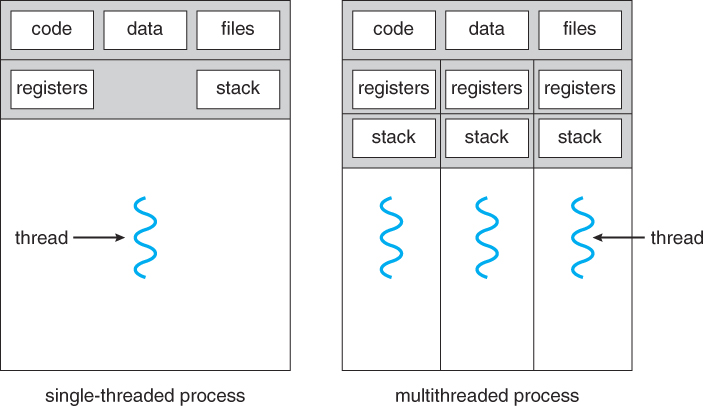
</div>
<center>
    Ilustración de la diferencia entre proceso con un solo hilo y multihilo. <a href="https://www.cs.uic.edu/~jbell/CourseNotes/OperatingSystems/4_Threads.html">Fuente</a>
</center>

&nbsp;
&nbsp;

<div>
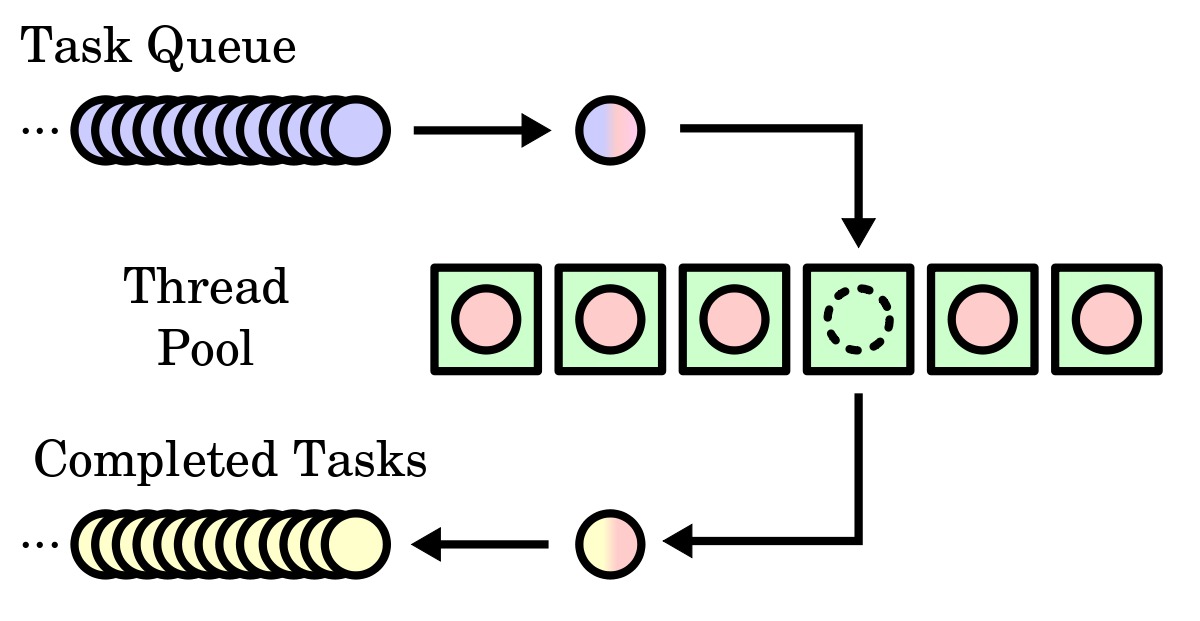
</div>
<center>
    Ilustración de la asignación de tareas a hilos. (Wikimedia Commons)
</center>

In [ ]:
@spawn println("Hola del hilo ", Threads.threadid())

In [ ]:
x = 1

@spawn begin
    #Ciclo infinito, no hace nada mientras x sea 1
    while x == 1
    end
    println("x ha cambiado de valor")
end

In [ ]:
x = 0

In [ ]:
for i = 1:8
    @spawn println("Hola del hilo ", Threads.threadid())
end

Julia ofrece soporte para ciclos paralelizables por medio del macro `@threads`

In [ ]:
@threads for i = 1:8
    println("Hola del hilo ", Threads.threadid())
end

- Por lo general, `@threads` funciona mejor para ciclos con iteraciones de tiempo uniforme.
- `@spawn` funciona mejor para paralelismo desbalanceado y anidado.

Ya que el soporte para hilos múltiples es una extensión a los `Task`, se pueden utilizar todas las funcionalidades relevantes vistas anteriormente.

In [ ]:
@spawn begin
    println("Iniciando tarea en el hilo ", Threads.threadid())
    sleep(5);
    println("mundo");
end

println("hola")

In [ ]:
#@threads espera a que finalicen los hilos generados para resolver el ciclo, por lo que usamos
# el macro @async para que la tarea del ciclo sea invocar y no finalizar.
@threads for n in 1:10
    @async begin
        i = 1
        h = Threads.threadid()
        while i < 20
            put!(ch_metricas, "[" * Dates.format(now(), "HH:MM:SS")*"] Hilo " * string(h))
            i += 1
            sleep(0.5)
        end
    end
end

- macOS/UNIX/Linux: `;ls`
- Windows: `;dir`

In [ ]:
;ls

- macOS/UNIX/Linux: `;cat 7.log`
- Windows: `;type 7.log`

In [ ]:
;cat 7.log

### Efectos secundarios y condiciones de carrera

#### Previo: Referencias

Necesidad de la referencia:

In [ ]:
a = 0

In [ ]:
function cambia_a()
    a = 23
    #¿Y global?
end

cambia_a()

In [ ]:
a

El comportamiento no es lo que parecería al inicio. Esto se arregla al usar una referencia.

In [ ]:
a = Ref(0)

In [ ]:
function cambia_a_ref()
   a[] = 23 
end

cambia_a_ref()

In [ ]:
a[]

Para que no importe el contexto de donde llamamos al acumulador, utilizaremos una referencia.

**Dicho lo anterior:**

El paralelismo y concurrencia introducen la posibilidad de que existan condiciones de carrera. Por defecto, el código de Julia no presenta protecciones ante este hecho:

In [ ]:
#Una referencia donde se guardará el acumulador
acc = Ref(0)

In [ ]:
@threads for i in 1:1000
    acc[] += 1
end

In [ ]:
acc[]

Por lo general, para evitar efectos secundarios se recomienda solo utilizar funciones puras (sin efectos secundarios, cuya salida está completamente determinada por sus argumentos y nada más). Algunos ejemplos de funciones a evitar son:
- Funciones que terminan con `!` (en Julia estas por convención modifican sus argumentos, por lo que no son puras).
- Funciones con efectos secundarios como `rand`, que modifica `Base.GLOBAL_RNG`. En el caso de esta última, podría generar cadenas de números aleatorios idénticas en varios hilos.

Al evitar estos patrones, se puede tener un comportamiento predecible y correcto de los programas generados.

En muchos casos, evitar este tipo de funciones resulta difícil. Es por esto que para evitar condiciones de carrera existen muchas estrategias de sincronización.

#### Operaciones atómicas

Una forma de evitar condiciones de carrera es utilizar operaciones atómicas (indivisibles).

In [ ]:
a = Atomic{Int}(0)

In [ ]:
@threads for i in 1:1000
    Threads.atomic_add!(a, 1)
end

In [ ]:
a.value

Existen algunas operaciones atómicas ya implementadas en Julia como:

- `atomic_sub!`
- `atomic_and!`
- `atomic_max!`
- `atomic_xor!`

Entre otras. De igual manera, es posible implementar operaciones atómicas utilizando `atomic_fence` (aunque esto tiene una mayor complejidad).

Desgraciadamente, estas operaciones suelen agregar un tiempo de ejecución considerable. Por esto, su uso debe limitarse si se desea tener un programa bien optimizado.

#### Candados

Otro mecanismo para evitar condiciones de carrera son los candados. Cuando un hilo los adquire, los otros hilos que intentan acceder al código no pueden hacerlo.

In [ ]:
a = Ref(0)

In [ ]:
lk = ReentrantLock()

@threads for i in 1:1000
    lock(lk) do
        a[] = a[] + 1
    end
end

In [ ]:
a[]

#### Encapsulamiento

Cuando se desea compartir recursos de forma más compleja, una de las formas más robustas para evitar las condiciones de carrera puede ser encapsulando los recursos.

En este, una sola tarea tiene acceso al recurso, y cualquier acceso al mismo se hace comunicándose con la tarea. Esta es una característica del modelo de actores para cómputo concurrente, el cual se puede implementar fácilmente en Julia utilizando procesos y canales.

<div>
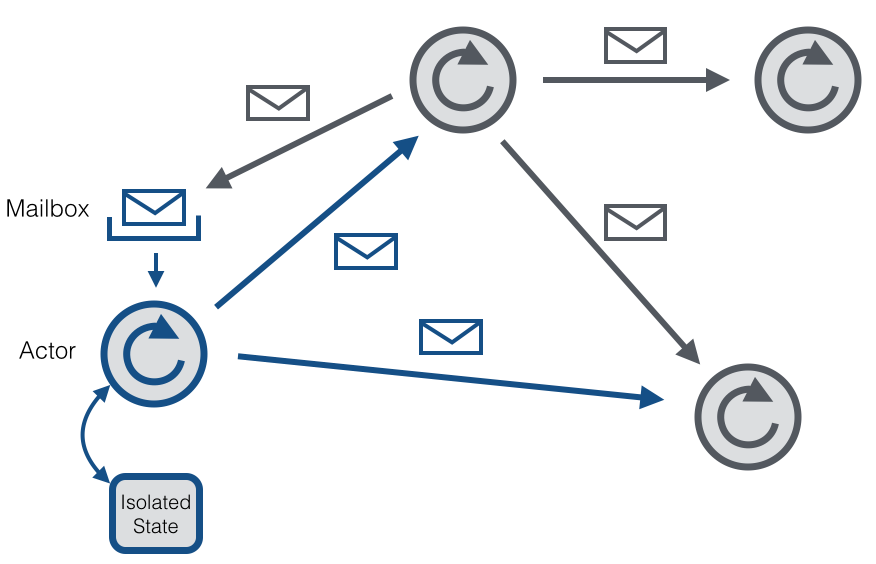
</div>
<center>
    Ilustración del modelo de actores (Apache Foundation).
</center>

In [ ]:
a = Ref(0)

ch = Channel{Int}(0)

#La tarea que puede modificar el contador
co = @spawn for i in ch
   a[] = a[] + 1 
end

In [ ]:
#Las tareas que quieren incrementar el contador
@threads for i in 1:1000
    put!(ch, 1)
end

In [ ]:
a[]

Es importante aclarar que los mecanismos mostrados previamente (en particular las operaciones atómicas y candados) permiten generar programas concurrentes correctos, pero esto lo logran **limitando** la ejecución paralela (secuencializando procesos). Esto implica que efectivamente generan un cuello de botella en el flujo de información. La mejor manera de escribir programas de alto desempeño es utilizando patrones de datos paralelos (map, reduce, etc...)

&nbsp;
&nbsp;
<div>
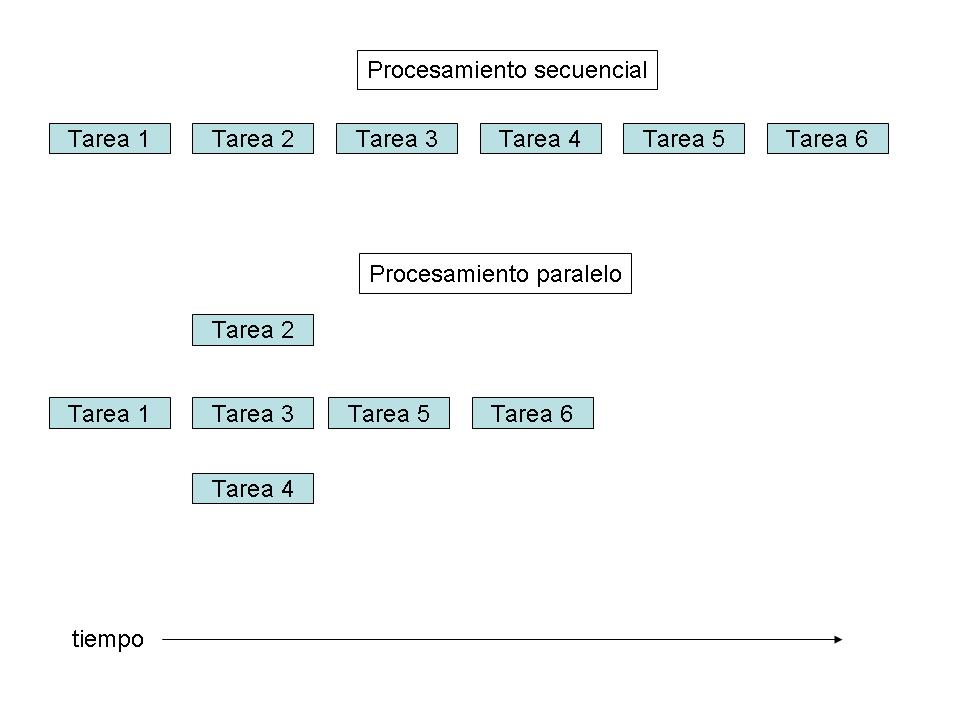
</div>
<center>
    Ilustración del tiempo de procesamiento secuencial y paralelo. <a href="http://sinapsis-aom.blogspot.com/2011/01/procesamiento-secuencial-y-paralelo.html?m=0">Fuente</a>
</center>
&nbsp;
&nbsp;

Aunque describir todos los casos de uso de los patrones de datos paralelos queda fuera de las metas de este curso, estos conceptos se utilizan implícitamente en la paralelización de operaciones.

### Paralelización de operaciones

Existen varios paquetes de Julia que proveen reemplazos para operaciones paralelizables. Con estos, es sumamente sencillo acelerar la ejecución de código dividiendo los problemas en múltiples hilos que corren en paralelo.

In [ ]:
#using Pkg
#Pkg.add("ThreadsX")
using ThreadsX

Aproximando $\pi$

In [ ]:
@btime sqrt(6 * sum(1/n^2 for n in 1:1_000_000_000))

In [ ]:
@btime sqrt(6 * ThreadsX.sum(1/n^2 for n in 1:1_000_000_000))

Ordenamiento

In [ ]:
a = rand(10_000_000);

In [ ]:
@btime sort($a);

In [ ]:
@btime ThreadsX.sort($a);

Mapeo

In [ ]:
f(x) = (log(x^2) + exp(x))^2 - x^(-1/4)

In [ ]:
@btime map(f, $a);

In [ ]:
@btime ThreadsX.map(f, $a);

***

## Cómputo distribuido

La implementación para cómputo con memoria paralela distribuida en Julia se encuentra provista por el módulo `Distributed`. Este concepto es util tanto como para computadoras con múltiples CPUs así como clusters de múltiples computadoras.

Así como con los hilos, puede iniciarse Julia con múltiples trabajadores con `julia -p [n/auto]`. También pueden agregarse después de lanzar Julia utilizando la instrucción `addprocs`.

Hay que recordar la diferencia entre un hilo y un proceso. Esto es más obvio cuando se está pensando en clusters que en una misma computadora.

In [ ]:
using Distributed

#Agregamos 8 trabajadores
addprocs(8)

In [ ]:
#Visualizamos el número de trabajadores disponibles
Distributed.nworkers()

Julia implementa los conceptos de cómputo distribuido a través del paso de mensajes unilateral basado en dos primitivas:
- **Referencia remota**: Un objeto que puede usarse desde cualquier proceso para referirse a un objeto almacenado en un proceso particular.
- **Llamada remota**: La petición de un proceso para llamar una función con ciertos argumentos en otro (o el mismo) proceso.

#### Referencias remotas

Existen dos tipos:

- `Future`
- `RemoteChannel`

Una llamada remota regresa un `Future` a su resultado inmediatamente. El proceso que realiza de la llamada entonces tiene la libertad de realizar otras tareas mientras la llamada remota se ejecuta en otro lugar. Se puede esperar al resultado del `Future` utilizando `wait`, y para leerlo se utiliza `fetch`.

Por el otro lado, los `RemoteChannel` son una extensión a los `Channel` vistos previamente. Ya que su interfaz es virtualmente idéntica a lo visto previamente, no ahondaremos en ellos.

Para generar una llamada remota, se utiliza la función `remotecall`. Los argumentos que recibe son:
- La función a ejecutar.
- El id del proceso en el que lo debe ejecutar.
- El resto son los argumentos pasados a la función.

In [ ]:
#Generando una matriz aleatoria de 2x2 en el proceso con id = 2.
r = remotecall(rand, 2, 2, 2)

Se puede utilizar el macro `@spawnat` para generar una tarea en un proceso dado. Se puede utilizar `:any` en vez de un id para que Julia decida automáticamente en qué proceso ejecutarlo.

In [ ]:
#Se suma 1 a cada elemento de la matriz.
#Como r existía en el proceso 2, la operación fetch(r) es instantánea.
s = @spawnat 2 1 .+ fetch(r)

In [ ]:
#Realizamos el fetch del resultado original, r
fetch(r)

In [ ]:
#Realizamos el fetch del segundo resultado, s
fetch(s)

Intentando realizar `fetch` en un `Future` asignado a un proceso sin terminar.

In [ ]:
f_1 = @spawnat :any begin
    sleep(10)
    return :ok
end

In [ ]:
#Se bloquea la ejecución hasta que termina el proceso asociado.
fetch(f_1)

Una característica importante es que el código que se desee ejecutar debe estar disponible en todo proceso que lo ejecuta.

In [ ]:
function rand2(dims...)
    return 2*rand(dims...)
end

In [ ]:
rand2(2,2)

In [ ]:
fetch(@spawnat :any rand2(2,2))

En este caso, el único proceso que conoce la función es el que está ejecutando el REPL de Julia. Para ejecutar una expresión en el `Main` de todos los procesos asociados, se puede usar el macro `@everywhere`.

In [ ]:
#Definiendo la función rand2 en todos los procesos activos de Julia.
@everywhere function rand2(dims...)
    return 2*rand(dims...)
end

In [ ]:
rand2(2,2)

In [ ]:
fetch(@spawnat :any rand2(2,2))

### Clusters

Una instalación de Julia tiene soporte para dos tipos de clusters por defecto:

- Clusters locales, lanzados con la opción `-p` o usando `addprocs`
- Clusters en red, utilizando la opción `--machine-file`. Esto permite utilizar un login ssh sin password para iniciar procesos trabajadores de Julia en las direcciones especificadas. También es posible generar tipos de clusters distintos con el paquete `ClusterManagers.jl`

### Paralelización de procesos

La paralelización de procesos se apoya en paradigmas de programación que permiten plantear problemas de tal forma que un resultado se segmente en fragmentos independientes. Esto lleva a que distintos procesos puedan trabajar sobre partes del problema, ahorrando tiempo de ejecución en el mundo real.

A continuación se mostrará el paradigma de **reducción**. En este, existen diversos procesos que actúan sobre distintas partes del problema. Al terminar estos, los resultados se integran (generalmente se reducen en dimensionalidad, de ahí el nombre de reducción).

In [ ]:
# Ejemplo, simulación con Monte-Carlo crudo de la fracción de puntos
# dentro de un círculo con radio r.
@everywhere function aproxima_area_◯(n, r)
    c::Int = 0
    rad = r^2
    for i = 1:n
        r1, r2 = rand(), rand()
        if r1^2 + r2^2 <= rad
            c += 1
        end
    end
    c
end

In [ ]:
#Dos experimentos
a = @spawnat :any aproxima_area_◯(1_000_000, 1)
b = @spawnat :any aproxima_area_◯(1_000_000, 1)

In [ ]:
#Reducción con suma
red = fetch(a) + fetch(b)
#Se obtiene la aproximación. La fracción de puntos dentro del círculo por el área del cuadrado envolvente.
4 * (red)/2_000_000

En este caso, nos limitamos a paralelizar los cálculos a dos procesos. Esto se puede generalizar utilizando el macro `@distributed`.

In [ ]:
red = @distributed (+) for i = 1:2_000_000
    r1, r2 = rand(), rand()
    Int(r1^2 + r2^2 <= 1)
end

4 * (red)/2_000_000

El macro `@distributed` implementa un patrón en el cual:
- Se asignan iteraciones a distintos procesos.
- Opcionalmente, se combinan los resultados de las iteraciones con una reducción dada (suma en este caso).

Hay que tomar en cuenta que los operadores de reducción deben ser asociativos y en muchos casos, conmutativos.

El patrón de reducción es uno de los más utilizados en el cómputo paralelo. Existen otros que tienen usos distintos, pero por límites de tiempo nos abstendremos de cubrirlos. Por lo general, existen múltiples consideraciones que se deben tener en mente al utilizar procesamiento distribuido:

- Cuando se requieran, utilizar estructuras de memoria compartida como `SharedArray`.
- Si es posible, delegar secciones de memoria exclusivas a ciertos procesos. Esto puede permitir utilizar memoria compartida sin mecanismos de sincronización, evitando los cuellos de botella.
- El tiempo de transferencia entre procesos.
- La capacidad de paralelismo.

El último punto es de gran importancia para el siguiente tema. En muchos casos, contar con los recursos suficientes para tener cientos o miles de procesos paralelos no es viable. Usar GPUs hace que muchas aplicaciones que antes requerían de un cluster y grandes cantidades de recursos se puedan resolver (y hasta en menos tiempo) utilizando hardware disponible para un consumidor cualquiera.